In [1]:
import datetime
import io
import logging

import dateutil
import datetime
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
### Mock parameters

if 0:
    # Countermeasures
    CMs = ["Stay home", "Respirators"]
    nCMs = len(CMs)
    # Countries
    Cs = ["CZ", "SK", "DE", "PL"]
    nCs = len(Cs)
    # Days
    Ds = [f"03-{i}" for i in range(10, 21)]
    nDs = len(Ds)

    # Probability of testing positive after transmission, from 0
    DelayProb = [0.1 for i in range(10)]

    ### Mock input data

    # [country, CM, day] Which CMs are active, and to what extent
    ActiveCMs = np.random.exponential(0.2, size=(nCs, nCMs, nDs)).astype(theano.config.floatX)

    # Mock growth rate [country, day]
    grate = np.random.lognormal(0.2, 0.2, size=(nCs, nDs))
    # cummulation of the daily rates * measurememt error
    Confirmed = np.cumprod(grate, axis=1) * np.random.lognormal(0.0, 0.3, size=(nCs, nDs)).astype(theano.config.floatX)
    #Confirmed[:,7] = np.nan

In [15]:
from datalib.region_data import RegionDataset
rds = RegionDataset.from_csv('data/regions.csv')
rds.read_csv_groups('data/data')
print(rds.col_groups)

[2020-03-31 14:16:39,960] INFO(datalib.region_data): Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
[2020-03-31 14:16:39,963] INFO(datalib.region_data): Loading group JH from data/data-JH.csv ...
[2020-03-31 14:16:40,259] INFO(datalib.region_data): Loading group SCM from data/data-SCM.csv ...


{'basic': ['Level', 'Name', 'OfficialName', 'OtherNames', 'Continent', 'Subregion', 'Country', 'ISOa3', 'M49Code', 'Lat', 'Lon', 'Population'], 'JH': {'JH_Confirmed', 'JH_Recovered', 'JH_Deaths', 'JH_Active'}, 'SCM': {'Activity cancellation', 'Diagnostic criteria loosened', 'Assisting people to stay home', 'Testing', 'Symptomatic isolation - targeted', 'Asymptomatic isolation - blanket', 'Domestic travel restriction', 'Symptomatic isolation - blanket', 'Public education and incentives', 'Gatherings banned', 'Public cleaning', 'Healthcare specialisation', 'Symptomatic isolation - semi-targeted', 'Miscellaneous hygiene measures', 'Nonessential business suspension', 'Diagnostic criteria tightened', 'Asymptomatic isolation - semi-targeted', 'International travel restriction', 'Hand washing', 'Asymptomatic isolation - targeted', 'School closure', 'Testing criteria', 'Public interaction reduction', 'Resumption', 'Mask wearing', 'Contact tracing'}}
Asymptomatic isolation - semi , 0.000, 0.039

In [27]:
### Real params and data

if 1:
    # Countermeasures
    CMs = ['Asymptomatic isolation - semi-targeted', 'International travel restriction', 'School closure', 'Healthcare specialisation', 'Resumption', 'Asymptomatic isolation - targeted', 'Assisting people to stay home', 'Diagnostic criteria tightened', 'Public cleaning', 'Asymptomatic isolation - blanket', 'Public interaction reduction', 'Domestic travel restriction', 'Symptomatic isolation - targeted', 'Nonessential business suspension', 'Mask wearing', 'Public education and incentives', 'Activity cancellation', 'Testing criteria', 'Symptomatic isolation - blanket']
    #CMS += ['Gatherings banned', 'Contact tracing', 'Testing']
    nCMs = len(CMs)
    # Countries
    Cs = ["DK", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "HU", "NO", "RO", "SE", "SI", "SK"]
    nCs = len(Cs)
    # Days
    FullDs = [datetime.date(2020,2,i) for i in range(20, 30)] + [datetime.date(2020,3,i) for i in range(1, 29)]
    # HACK: Assume fixed 7 days to CM effect
    CM_Ds = FullDs[:-7]
    JH_Ds = FullDs[7:]
    JHName = "JH_Confirmed"
    # Deaths!
    CM_Ds = FullDs[:-14]
    JH_Ds = FullDs[14:]
    JHName = "JH_Deaths"

    nDs = len(CM_Ds)

    # Probability of testing positive after transmission, from 0
    DelayProb = [0.00, 0.01, 0.02, 0.05, 0.09, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03, 0.01, 0.01]

    # [country, CM, day] Which CMs are active, and to what extent
    sd = rds.series.loc[Cs, CMs]
    for cm in CMs:
        d = rds.series[cm]
        print(f"{cm[:29]:30}, {d.min().min():.3f}, {d.mean().mean():.3f}, {d.max().max():.3f}")
        rds.series[cm] /= d.max().max()
    ActiveCMs = np.stack([sd.loc[Cs, [(cm, d) for d in CM_Ds]].values for cm in CMs], axis=1)
    assert ActiveCMs.shape == (nCs, nCMs, nDs)
    ActiveCMs = ActiveCMs.astype(theano.config.floatX)

    # [country, day]
    Confirmed = rds.series.loc[tuple(Cs), [(JHName, d) for d in JH_Ds]].values
    assert Confirmed.shape == (nCs, nDs)
    Confirmed[Confirmed < 5.0] = np.nan
    Confirmed = np.ma.masked_invalid(Confirmed.astype(theano.config.floatX))


Asymptomatic isolation - semi , 0.000, 0.008, 1.000
International travel restrict , 0.000, 0.166, 1.000
School closure                , 0.000, 0.021, 1.000
Healthcare specialisation     , 0.000, 0.008, 1.000
Resumption                    , 0.000, 0.002, 1.000
Asymptomatic isolation - targ , 0.000, 0.011, 1.000
Assisting people to stay home , 0.000, 0.009, 1.000
Diagnostic criteria tightened , 0.000, 0.004, 1.000
Public cleaning               , 0.000, 0.004, 1.000
Asymptomatic isolation - blan , 0.000, 0.030, 1.000
Public interaction reduction  , 0.000, 0.004, 1.000
Domestic travel restriction   , 0.000, 0.012, 1.000
Symptomatic isolation - targe , 0.000, 0.116, 1.000
Nonessential business suspens , 0.000, 0.019, 1.000
Mask wearing                  , 0.000, 0.002, 1.000
Public education and incentiv , 0.000, 0.009, 1.000
Activity cancellation         , 0.000, 0.016, 1.000
Testing criteria              , 0.000, 0.006, 1.000
Symptomatic isolation - blank , 0.000, 0.009, 1.000


In [28]:
with pm.Model() as model:
    # [] Baseline growth rate (wide prior OK, mean estimates ~10% daily growth)
    BaseGrowthRate = pm.Lognormal("BaseGrowthRate", np.log(1.1), 2.0)
    # [country] Initial size of epidemic (the day before the start, only those detected; wide prior OK)
    InitialSize = pm.Lognormal("InitialSize", 0.0, 10, shape=(nCs,))
    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryGrowthRate = pm.Lognormal("CountryGrowthRate", pm.math.log(BaseGrowthRate), 0.2, shape=(nCs,))
    # [CM] How much countermeasures reduce growth rate
    # TODO: Estimate variance, or use another dist.
    #CMReduction = pm.Bound(pm.Lognormal, upper=1.0)("CMReduction", 0.0, 0.1, shape=(nCMs,))
    CMReduction = pm.Lognormal("CMReduction", 0.0, 0.1, shape=(nCMs,))
    # [country, CM, day] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReduction, (1, nCMs, 1)) ** ActiveCMs
    # [country, day] Reduction factor from CMs for each C,D (noise added below)
    GrowthReduction = pm.Deterministic("GrowthReduction", T.prod(ActiveCMReduction, axis=1))
    # [country, day] The ideal predicted daily growth
    PreictedGrowth = pm.Deterministic("PreictedGrowth", T.reshape(CountryGrowthRate, (nCs, 1)) * GrowthReduction)
    # [country, day] The actual (still hidden) growth each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyGrowth =  pm.Lognormal("DailyGrowth", pm.math.log(PreictedGrowth), 0.1, shape=(nCs, nDs))

    # Below I assume plain exponentia growth of confirmed rather than e.g. depending on actives etc.

    # [country, day] The number of cases that would be detected with noiseless testing
    # (Noise source includes both false-P/N rates and local variance in test volume and targetting)
    # (Since we ony care about growth rates and assume consistent testing, it is fine to ignore real size)
    Size = pm.Deterministic("Size", T.reshape(InitialSize, (nCs, 1)) * DailyGrowth.cumprod(axis=1))
    # [country, day] Cummulative tested positives
    Observed = pm.Lognormal("Observed", pm.math.log(Size), 0.4, shape=(nCs, nDs), observed=Confirmed)


In [29]:
print(model.check_test_point())
with model:
    trace = pm.sample(1000, chains=2, cores=4, init='adapt_diag', tune=1000)

[2020-03-31 14:45:04,172] INFO(pymc3): Auto-assigning NUTS sampler...
[2020-03-31 14:45:04,173] INFO(pymc3): Initializing NUTS using adapt_diag...


BaseGrowthRate_log__         -1.61
InitialSize_log__           -54.77
CountryGrowthRate_log__      11.74
CMReduction_log__            26.29
DailyGrowth_log__           564.53
Observed_missing              0.00
Observed                  -5176.18
Name: Log-probability of test_point, dtype: float64


[2020-03-31 14:45:06,290] INFO(pymc3): Multiprocess sampling (2 chains in 4 jobs)
[2020-03-31 14:45:06,291] INFO(pymc3): NUTS: [Observed_missing, DailyGrowth, CMReduction, CountryGrowthRate, InitialSize, BaseGrowthRate]
Sampling 2 chains, 1,115 divergences: 100%|██████████| 4000/4000 [10:40<00:00,  6.24draws/s]
[2020-03-31 14:55:52,415] ERROR(pymc3): There were 399 divergences after tuning. Increase `target_accept` or reparameterize.
[2020-03-31 14:55:52,416] WARNING(pymc3): The acceptance probability does not match the target. It is 0.6846672192765779, but should be close to 0.8. Try to increase the number of tuning steps.
[2020-03-31 14:55:52,417] ERROR(pymc3): There were 716 divergences after tuning. Increase `target_accept` or reparameterize.
[2020-03-31 14:55:52,418] WARNING(pymc3): The acceptance probability does not match the target. It is 0.4421375447952985, but should be close to 0.8. Try to increase the number of tuning steps.
[2020-03-31 14:55:52,418] ERROR(pymc3): The rhat 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10d8792b50>,
      dtype=object)

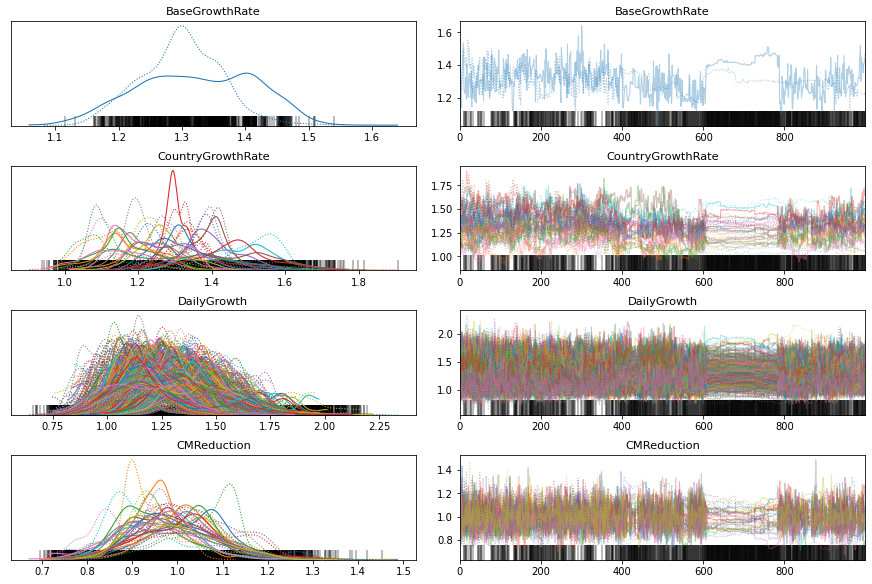

In [30]:
pm.traceplot(trace, var_names=["BaseGrowthRate", "CountryGrowthRate", "DailyGrowth", "CMReduction"])

0: Asymptomatic isolation - semi-targeted, 1: International travel restriction, 2: School closure, 3: Healthcare specialisation, 4: Resumption, 5: Asymptomatic isolation - targeted, 6: Assisting people to stay home, 7: Diagnostic criteria tightened, 8: Public cleaning, 9: Asymptomatic isolation - blanket, 10: Public interaction reduction, 11: Domestic travel restriction, 12: Symptomatic isolation - targeted, 13: Nonessential business suspension, 14: Mask wearing, 15: Public education and incentives, 16: Activity cancellation, 17: Testing criteria, 18: Symptomatic isolation - blanket


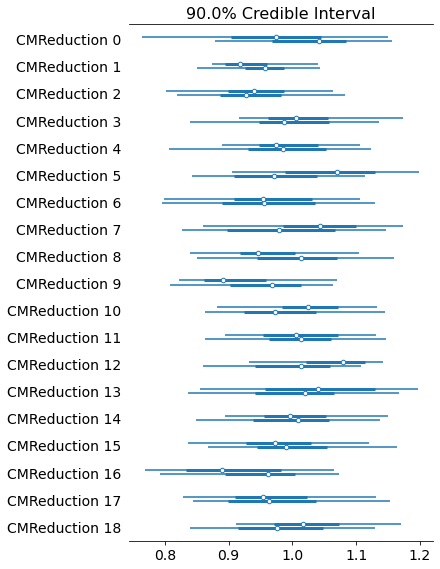

In [31]:
pm.forestplot(trace, varnames=['CMReduction'], credible_interval=0.9)
print(', '.join(f"{i}: {c}" for i, c in enumerate(CMs)))

NameError: name 'mpld3' is not defined